# Определение стоимости автомобилей
Заказчик (сервис по продаже автомобилей с пробегом) разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Заказчик предоставляет исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.



**План работы:**
1. Предобработка и исследовательский анализ данных.
2. Подготовка признаков для моделей.
3. Обучение моделей.
4. Анализ моделей и выбор наиболее подходящей под требования заказчика.

## 1 Подготовка данных

### 1.1 Знакомство с данными
Импортируем все необходимые для работы библиотеки, откроем файл с данными и изучим общую информацию о них.

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# импорт структур, модулей, функций
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
import category_encoders as ce
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# константа, фиксирующая случайность
rs = 12345

In [3]:
# чтение файла с данными и сохранение в таблицу df
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/autos.csv')
    
# просмотр первых пяти строк полученной таблицы
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# получение общей информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# получение характерных значений количественных признаков
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
# получение характерных значений категориальных признаков
df.describe(include=[object])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


1. В данных представлены 354369 записей о характеристиках и ценах автомобилей. Согласно документации:

признаки:
- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `NotRepaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя;

целевой признак:
- `Price` — цена (евро).

2. Названия признаков даны в верблюжьем регистре, надо исправить на змеиный.


3. Из 16 признаков имеются пропуски в следующих 5:
- `VehicleType` — тип автомобильного кузова;
- `Gearbox` — тип коробки передач;
- `Model` — модель автомобиля;
- `FuelType` — тип топлива;
- `NotRepaired` — была машина в ремонте или нет.

Из перечисленных пропусков однозначно нельзя восстановить информацию о том, была машина в ремонте или нет. Факт ремонта никак не связан с имеющимися характеристиками автомобилей. Данные пропуски заменяем на третью категорию - `unknown`.

Остальные пропуски хоть и находятся в признаках, имеющих некоторую связь, однако восстановить большинство из них всё же проблематично.

В данных встречается разный тип кузова у автомобилей с одинаковыми характеристиками (модель, мощность, тип топлива и коробки передач). Значит, пропуски заполняем категорией `unknown`.

Коробка передач бывает разной у автомобилей одинаковой модели, и этот признак не связан с остальными. Пропуски заполняем категорией `unknown`.

Разные модели автомобилей могут иметь одинаковые характеристики, поэтому по остальным признакам пропуски не заполнить. Заполняем категорией `unknown`.

Можно попробовать заменить пропуски в типе топлива, исходя из комбинации марки и мощности автомобиля (эти данные без пропусков) с моделью.

4. Типы данных соответствуют по смыслу содержимому признаков и требованиям модели.


5. По характерным значениям видно, что есть явные ошибки в заполнении некоторых признаков.
- Минимальное значение цены - 0 евро, такого быть не может.
- Минимальное и максимальное значения года регистрации не соответствуют действительности: 1000 и 9999.
- Минимальное и максимальное значения мощности также сомнительны: 0 и 20000 л.с.

Проанализируем позже эти ошибки и решим, что с ними делать.

6. Также проверим значения категориальных признаков на предмет опечаток и скрытых дублей.


7. Не все признаки важны для модели. Так, можно удалить следующие признаки:
- `DateCrawled` — дата скачивания анкеты из базы;
- `RegistrationMonth` - месяц регистрации автомобиля;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя.

### 1.2 Предобработка данных
Сначала проверим данные на наличие явных дубликатов и удалим их при наличии.

**Работа с дубликатами и стилями**

In [7]:
# просмотр количества явных дубликатов
print(df.duplicated().sum())
# удаление строк-дубликатов с обновлением индексов
# без создания столбца index
df = df.drop_duplicates().reset_index(drop=True) 
# просмотр размера таблицы
print(df.shape)

4
(354365, 16)


Из таблицы удалены 4 явных дубликата.

Теперь удалим не нужные для обучения модели признаки, а названия остальных приведём к змеиному регистру.

Дата скачивания и создания анкеты, количество фотографий, почтовый индекс владельца и дата последней активности никак не связаны с характеристиками и комплектацией автомобиля и, соответственно, не влияют на цену автомобиля. Также в данных есть признак "Месяц регистрации автомобиля". Теоретически, в связи с инфляцией цена одного и того же автомобиля в конце года может быть выше. Однако, ценообразование на автомобили несколько сложнее и подвержено влиянию других факторов. Поэтому данный признак также можно удалить.

In [8]:
# удаление не нужных для обучения модели признаков
df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated',
                      'NumberOfPictures', 'PostalCode', 'LastSeen'])
# приведение названий признаков к змеиному регистру
df = df.rename(columns={'VehicleType': 'vehicle_type',
                       'RegistrationYear': 'registration_year',
                       'Gearbox': 'gearbox',
                       'Power': 'power',
                       'Model': 'model',
                       'Kilometer': 'kilometer',
                       'FuelType': 'fuel_type',
                       'Brand': 'brand',
                       'NotRepaired': 'not_repaired',
                       'Price': 'price'})
# просмотр названий признаков
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

Лишние признаки удалены, стиль названий исправлен.

Проверим категориальные признаки на предмет ошибок и скрытых дублей. 

In [9]:
# просмотр уникальных значений признака vehicle_type
print(df['vehicle_type'].unique())
# просмотр уникальных значений признака gearbox
print(df['gearbox'].unique())
# просмотр уникальных значений признака fuel_type
print(df['fuel_type'].unique())
# просмотр уникальных значений признака not_repaired
print(df['not_repaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
[nan 'yes' 'no']


В типах кузова и коробки передач, а также в факте ремонта ошибок нет.

В типе топлива есть скрытый дубликат: `petrol` и `gasoline` означают одно и то же топливо - бензин (`petrol` - британский термин, `gasoline` - американский). Заменим `gasoline` на `petrol`:

In [10]:
# замена gasoline на petrol в признаке fuel_type
df = df.replace({'fuel_type':{'gasoline':'petrol'}})
# просмотр уникальных значений признака fuel_type
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [11]:
# просмотр уникальных значений признака model в алфавитном порядке
print(pd.Series(df['model'].unique()).sort_values().values)

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'impreza' '

В названиях моделей ошибок нет. Проверим марки автомобилей.

In [12]:
# просмотр уникальных значений признака fuel_type
sorted(df['brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

В марках автомобилей ошибок также нет.

**Работа с пропусками**

Теперь заполним пропуски в признаках `vehicle_type`, `gearbox`, `model`, `not_repaired` на `unknown`:

In [13]:
# признаки с пропусками, которые надо заменить на unknown
columns_nan = ['vehicle_type', 'gearbox', 'model', 'not_repaired']
# заполнение пропусков в признаках vehicle_type, gearbox, model, not_repaired
df[columns_nan] = df[columns_nan].fillna('unknown')
# просмотр оставшихся пропусков
df[columns_nan].isna().sum()

vehicle_type    0
gearbox         0
model           0
not_repaired    0
dtype: int64

Пропуски заполнены. Попробуем заполнить пропуски в типе топлива на основе совпадения марки, модели и мощности автомобиля. Оставшиеся пропуски заполним категорией `unknown`. До и после заполнения пропусков посмотрим на распределение количества объектов по типам топлива.

In [14]:
# подсчёт количества объектов по типам топлива
df.groupby('fuel_type')['fuel_type'].count()

fuel_type
cng            565
electric        90
hybrid         233
lpg           5310
other          204
petrol      315068
Name: fuel_type, dtype: int64

In [15]:
# просмотр количества пропусков в признаке fuel_type
# до заполнения пропусков
print(df['fuel_type'].isna().sum())
# заполнение пропусков в признаке fuel_type
df['fuel_type'] = df['fuel_type'].fillna(
    df.groupby(['brand', 'model', 'power'])['fuel_type'].transform('first'))
# просмотр количества пропусков в признаке fuel_type
# после заполнения пропусков
print(df['fuel_type'].isna().sum())
# заполнение оставшихся пропусков категорией unknown
df['fuel_type'] = df['fuel_type'].fillna('unknown')

32895
867


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       354365 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          354365 non-null  object
 8   brand              354365 non-null  object
 9   not_repaired       354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [17]:
# подсчёт количества объектов по типам топлива
df.groupby('fuel_type')['fuel_type'].count()

fuel_type
cng            586
electric        95
hybrid         236
lpg           5695
other          227
petrol      346659
unknown        867
Name: fuel_type, dtype: int64

Пропуски заполнены, распределение объектов по видам топлива сохранилось.

**Работа с ошибками. Цена**

Посмотрим на ошибки в цене. Построим гистограмму по всем значениям.

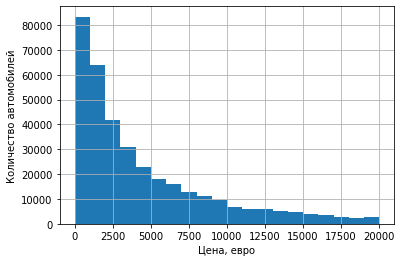

In [18]:
# построение гистограммы по цене
df['price'].hist(bins=20)
plt.xlabel('Цена, евро')
plt.ylabel('Количество автомобилей')
plt.show()

По гистограмме видно, что частотность цен закономерно уменьшается при увеличении цены. Наибольшее количество объектов имеет цену от 0 до 2000 евро.

Однако, автомобиль не может стоить 0 евро. Даже если принять, что автомобиль находится в полностью нерабочем состоянии, его можно оценить как металлолом. Произведём грубую оценку: легковой автомобиль в среднем имеет массу 1,5 т. 1 кг чёрного металла стоит порядка 20 руб. Значит, если не брать во внимание составляющие из цветных металлов, которые на порядок дороже чёрного металла, и другие материалы, то цена нерабочего автомобиля может составить 1500 * 20 / 75 = 400 евро. Таким образом, низкие цены являются, скорее всего, ошибочно введёнными данными.

При этом, из жизни известно, что цена старых (10 лет и более) автомобилей может колебаться в диапазоне от 100 до 400 евро.

В реальной задаче можно было бы уточнить у заказчика возможные причины появления низких цен, а также "порог адекватности" цены. Дальше, при условии, что заказчик работает с автомобилями состояния "металлолом", можно точнее составить формулу определения цены таких автомобилей.

Поскольку дополнительными данными мы не располагаем, посмотрим на количество и распределение цен в диапазоне от 0 до 400 евро и примем решение, что делать с такими ценами.

In [19]:
# подсчёт количества объектов с ценой ниже 400 евро
df.query('price < 400')['price'].count()

30019

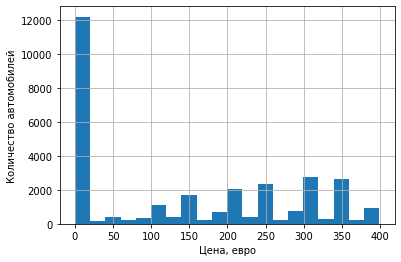

In [20]:
# построение гистограммы по ценам ниже 400 евро
df.query('price < 400')['price'].hist(bins=20)
plt.xlabel('Цена, евро')
plt.ylabel('Количество автомобилей')
plt.show()

В данных около 8,5% объектов имеют цену ниже 400 евро. Такое количество информации терять не хочется. По гистограмме видно, что есть большое количество нулевых и близких к ним (меньше 10 евро) цен. Это явные ошибочно введённые данные, которые не очень понятно, как можно исправить. В диапазоне от 10 до 100 евро не очень много данных, они явно тоже ошибочны. А далее наблюдаются всплески вокруг "круглых" значений, которые соответствуют правильным или похожим на правильные значениям.

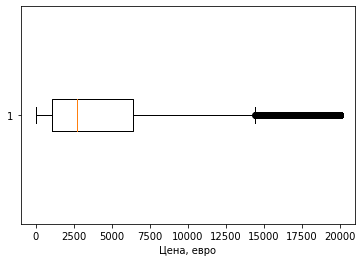

In [21]:
# построение диаграммы размаха для цены
plt.boxplot(df['price'], vert=0)
plt.xlabel('Цена, евро')
plt.show()

In [22]:
# расчёт нижней границы нормального диапазона
print(
    2.5 * (np.percentile(df['price'], \
                         25 , \
                         interpolation = 'midpoint' )
          )
    - 1.5 * (np.percentile(df['price'], \
                           75 , \
                           interpolation = 'midpoint' )
            )
)

-6975.0


По диаграмме размаха видно, что все низкие цены попадают в диапазон нормальных значений. Расчёт нижней границы это подтверждает. Однако, здесь математика противоречит здравому смыслу. Поэтому удаляем из данных автомобили с ценами ниже 100 евро, принимая, что остальные низкие цены имеют место быть для либо очень старых, либо в очень плохом состоянии автомобилей.

In [23]:
# удаление объектов с ценами ниже 100 евро
df = df.loc[df['price'] >= 100]

In [24]:
# просмотр размера таблицы
df.shape

(341051, 10)

Удалено чуть меньше 4% данных.

**Работа с ошибками. Год регистрации**

Следующий важный признак, в котором есть ошибки, это год регистрации автомобиля. Минимальное значение - 1000, максимальное - 9999, очевидно, не верные значения. Посмотрим, какие ещё есть значения этого признака, не соответствующие действительности.

In [25]:
# просмотр уникальных значений признака registration_year
sorted(df['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Значения до 1910 года явно ошибочны, т.к. первый автомобиль с ДВС изобретён в 1885 году. Вместе с тем, маловероятны годы выпуска первой половины XX века. Проверим это по диаграмме размаха и гистограмме.

Все годы после 2016 года также ошибочны, потому что автомобиль не может быть зарегистрирован позже, чем об этом указано в объявлении. А объявления датируются 2016 годом.

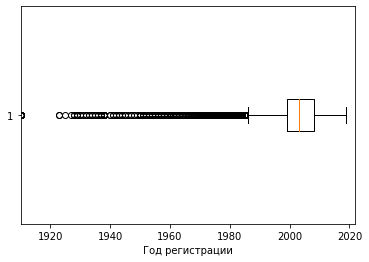

In [26]:
# построение диаграммы размаха для года регистрации
plt.boxplot(df['registration_year'], vert=0)
plt.xlim(1910, 2022)
plt.xlabel('Год регистрации')
plt.show()

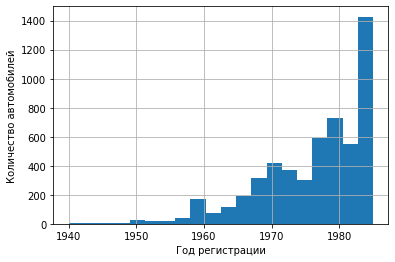

In [27]:
# построение гистограммы по году регистрации
df['registration_year'].hist(range=(1940, 1985), bins=20)
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.show()

По диаграмме размаха все года раньше 1985 являются выбросами. Однако, по гистограмме видно, что где-то до 1950 года автомобили не единичны. Поэтому оставляем в данных годы выпуска с 1950-го. Посмотрим на диапазон более поздних годов.

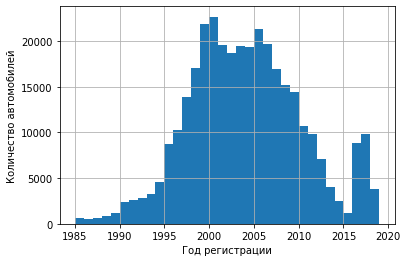

In [28]:
# построение гистограммы по году регистрации
df['registration_year'].hist(range=(1985, 2019), bins=34)
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.show()

На диаграмме виден странный всплеск в 2017 году - чуть меньше 10 тыс. автомобилей. В реальной задаче опять же можно было бы узнать у заказчика, как может быть указан год регистрации 2017 г. при том, что анкета создана и выгружена из базы в 2016 году.
Поскольку возможности уточнения нет, необъяснимые данные убираем.

Итак, оставляем в данных объекты с годами регистрации с 1950 по 2016 гг.

In [29]:
# удаление объектов с годами регистрации ранее 1950 г. и позднее 2016 г.
df = df.loc[(df['registration_year'] >= 1950) & (df['registration_year'] <= 2016)]
# просмотр размера таблицы
df.shape

(327219, 10)

Объекты с ошибочными годами регистрации удалены; осталось 92,3% исходных данных.

**Работа с ошибками. Мощность**

Остались ошибки в мощности автомобилей. Минимальное - 0 л.с. - и максимальное - 20000 л.с. - значения не правдоподобны. Посмотрим, какие и в каком количестве есть значения этого признака.

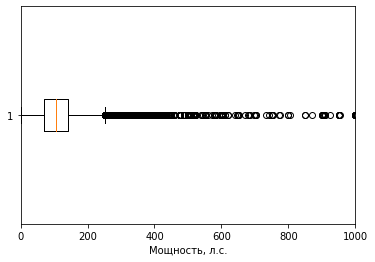

In [30]:
# построение диаграммы размаха для мощности
plt.boxplot(df['power'], vert=0)
plt.xlim(0, 1000)
plt.xlabel('Мощность, л.с.')
plt.show()

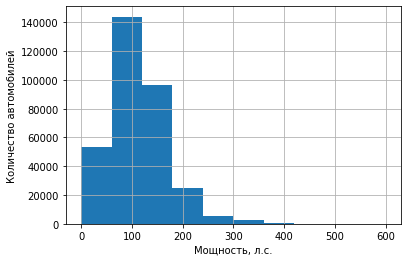

In [31]:
# построение гистограммы по мощности
df['power'].hist(range=(0, 600))
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

In [32]:
# просмотр количества объектов с мощностью выше 600 л.с.
df.query('power > 600')['power'].count()

324

Значения мощности выше 600 л.с. - крайне неправдоподобны; их мало. По диаграмме размаха значения выше 250 л.с. можно считать выбросами. Также по диаграмме размаха видно, что в диапазоне от 250 л.с. до 600 л.с. значений довольно много.
Посмотрим на список моделей автомобилей в этом мощностном диапазоне. 

In [33]:
sorted(df.query('power > 250 and power <= 600')['model'].unique())

['100',
 '159',
 '1_reihe',
 '1er',
 '200',
 '300c',
 '3_reihe',
 '3er',
 '5er',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '911',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'accord',
 'astra',
 'beetle',
 'boxster',
 'bravo',
 'c_klasse',
 'calibra',
 'captiva',
 'cayenne',
 'cc',
 'cherokee',
 'civic',
 'cl',
 'clio',
 'clk',
 'cooper',
 'corsa',
 'crossfire',
 'cuore',
 'cx_reihe',
 'discovery',
 'e_klasse',
 'focus',
 'g_klasse',
 'galant',
 'galaxy',
 'gl',
 'glk',
 'golf',
 'grand',
 'impreza',
 'insignia',
 'juke',
 'kadett',
 'lancer',
 'legacy',
 'leon',
 'm_klasse',
 'm_reihe',
 'matiz',
 'megane',
 'mustang',
 'octavia',
 'omega',
 'other',
 'passat',
 'phaeton',
 'polo',
 'q5',
 'q7',
 'range_rover',
 'range_rover_evoque',
 'range_rover_sport',
 'rx_reihe',
 's_klasse',
 's_max',
 's_type',
 'santa',
 'scirocco',
 'sl',
 'slk',
 'spider',
 'superb',
 'touareg',
 'tt',
 'twingo',
 'unknown',
 'v60',
 'v70',
 'vectra',
 'viano',
 'x_reihe',
 'x_type',
 'xc_reihe',
 'z_reihe',
 'zafira']

В списке присутствуют как действительно мощные автомобили (например, Ford Mustang - до 500 л.с.; Mercedes-Benz E-class - до 600 л.с.), так и не очень правдоподобные значения(к примеру, Сhevrolet Matiz - менее 100 л.с., Skoda Octavia - менее 200 л.с.). Возможно, это тюнингованные автомобили? По гистрограмме видно, что где-то после 400 л.с. автомобилей совсем мало. Примем это значение верхней границей и удалим все объекты с большей мощностью.

In [34]:
# просмотр количества объектов с мощностью выше 400 л.с.
df.query('power > 400')['power'].count()

650

Теперь посмотрим на область низких значений.

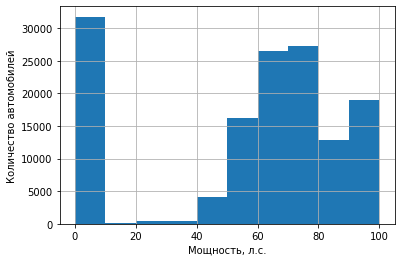

In [35]:
# построение гистограммы по мощности
df['power'].hist(range=(0, 100))
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

In [36]:
# просмотр количества объектов с мощностью 0 л.с.
df.query('power == 0')['power'].count()

31555

Очень большое количество объектов (около 10%) имеют нулевую мощность, чего быть не может. Либо её не знали при заполнении анкеты, либо ошиблись при вводе, либо произошёл сбой, и данные не сохранились. Удалять эти объекты не стоит, но и оставлять с нулёвой мощностью не правильно. Можно попробовать заполнить эти значения медианой по сочетанию марки, модели, типа топлива и типа кузова. А оставшиеся значения можно будет удалить.

Объекты с мощностью 20 л.с. и менее также удаляем, их мало, и такие значения неправдоподобны. 

Для современного мира мощность автомобиля 20...40 л.с. является неправдоподобно низкой. Однако, в данных мы оставили автомобили с годом регистрации, начиная с 1950 г. И старые автомобили как раз могут иметь такую мощность. Посмотрим на распределение количества автомобилей по маркам с мощностями от 20 до 40 л.с.

In [37]:
# просмотр количества объектов по маркам с мощностью от 20 до 40 л.с.
df.query('power > 20 and power < 40').groupby('model')['model'].count()

model
1_reihe       4
500          29
601         218
a6            1
arosa         6
astra         1
c2            1
c_klasse      1
cooper        1
corsa        22
cuore         3
fiesta        6
fortwo       17
ka            3
kadett        2
kaefer      127
lupo         12
matiz         2
micra         2
move          1
other       250
panda         9
polo         24
roadster      1
seicento     47
sharan        1
sorento       1
swift         6
twingo        1
unknown      85
Name: model, dtype: int64

In [38]:
# просмотр количества объектов по маркам с мощностью от 20 до 40 л.с. и маркой other
df.query('power > 20 and power < 40 and model =="other"').groupby('registration_year')['registration_year'].count()

registration_year
1950     1
1951     1
1952     2
1954     1
1955     2
1958     1
1959     3
1960     8
1961     3
1962     4
1963     2
1965     5
1966     3
1967     2
1968     3
1969     2
1970     4
1971     3
1972     4
1974     7
1975     2
1976     1
1977     1
1978    12
1979     1
1980     5
1981     6
1982     5
1983     3
1984    11
1985    15
1986    16
1987    10
1988    14
1989    14
1990     6
1991     3
1992     5
1993     9
1994     9
1995     4
1996    17
1997    10
1998     2
1999     2
2000     2
2001     2
2016     2
Name: registration_year, dtype: int64

В данной мощностной группе больше всего автомобилей марки 'other'. Возможно, модель этих автомобилей не указывалась, либо её не было в выпадающем списке (если анкета так устроена). Это действительно, в основном старые автомобили.

Следующая по многочисленности группа (218 штук) - это автомобиль марки 601. Это *Trabant*, выпускавшийся с 1957 г. в ГДР. Его мощность - 26 л.с. (А изначально - вообще 18 л.с.)

Далее идёт *Volkswagen Kaefer* (127 штук), выпускавшийся с 1946 г. Диапазон мощностей - от 25 до 50 л.с.

Ещё один пример - *Fiat Seicento* (47 штук). Выпускался с 1997 г. Мощность - от 39 до 55 л.с.

Несмотря на то, что приведённые автомобили составляют небольшой процент в данных, но всё же они есть на рынке и не являются ошибками, поэтому удалять их не правильно.

In [39]:
# замена нулевых мощностей на пропуски
df.loc[(df['power'] == 0), 'power'] = np.nan
# удаление объектов с мощнотью 20 л.с. и менее или более 400 л.с.
df = df.loc[(df['power'] > 20) & (df['power'] <= 400) | np.isnan(df['power'])]
# просмотр количества пропусков в признаке power
# до заполнения пропусков
print(df['power'].isna().sum())
# заполнение пропусков в признаке power
df['power'] = df['power'].fillna(
    df.groupby(['brand', 'model', 'fuel_type', 'vehicle_type'])['power'].transform('median'))
# просмотр количества пропусков в признаке power
# после заполнения пропусков
print(df['power'].isna().sum())
# удаление объектов с оставшимися пропусками
df = df.dropna(subset=['power'])
# замена типа данных признака power
df['power'] = df['power'].astype('int64')
# просмотр размера таблицы
print(df.shape)

31555
323
(325858, 10)


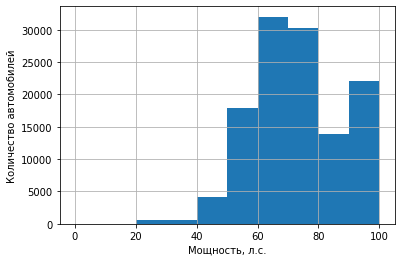

In [40]:
# построение гистограммы по мощности 0...100 л.с.
df['power'].hist(range=(0, 100))
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

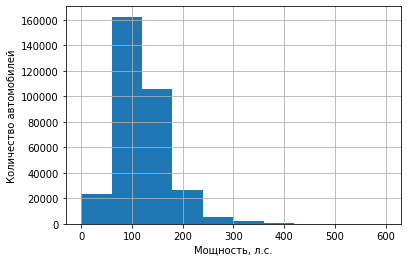

In [41]:
# построение гистограммы по мощности 0...600 л.с.
df['power'].hist(range=(0, 600))
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей')
plt.show()

Нулевые значения мощности заменены; значения, которые не удалось заменить, удалены. Общий характер гистограммы не изменился. Осталось 92% исходных данных.

**Работа с ошибками. Итоговый осмотр данных**

После всех преобразований проверим, что типы данных остались корректными и что характерные значения признаков адекватны.

In [42]:
# просмотр типов данных
df.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
not_repaired         object
dtype: object

In [43]:
# получение характерных значений количественных признаков
df.describe()

,price,registration_year,power,kilometer
count,325858.000000,325858.000000,325858.000000,325858.000000
mean,4634.660199,2002.656568,118.937197,128476.959289
std,4537.496332,6.699390,51.715167,37099.539430
min,100.000000,1950.000000,21.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2950.000000,2003.000000,110.000000,150000.000000
75%,6700.000000,2007.000000,145.000000,150000.000000
max,20000.000000,2016.000000,400.000000,150000.000000


In [44]:
# получение характерных значений категориальных признаков
df.describe(include=[object])

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,325858,325858,325858,325858,325858,325858
unique,9,3,250,7,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,88791,249241,26546,319212,70212,235701


Данные корректны и адекватны; значения характерных признаков почти не изменились (не считая изменённых нижних и верхних границ части признаков).

### 1.3 Подготовка признаков для простых моделей

В данных присутствуют категориальные признаки, их следует преобразовать в количественные.
Для признаков `gearbox`, `fuel_type`, `not_repaired` можно применить прямое кодирование, т.к. значений этих признаков не очень много.

А вот для признаков `model`, `brand` и `vehicle_type` следует применить порядковое кодирование, иначе мы получим огромное количество новых признаков (около 300). Для того, чтобы модель не считала одни значения более весомыми, чем другие, после порядкового кодирования следует применить двоичное.

**Подготовка признаков для линейной регрессии**

Для начала подготовим признаки для линейной регрессии. Ивлечём признаки в переменную `features` и целевой признак `price` в переменную `target`, после чего разделим исходные данные на обучающую и тестовую в соотношении 75:25.

In [45]:
# разделение на признаки и целевой признак и 
# отделение 25% исходных данных для тестовой выборки
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    df.drop(['price'], axis=1),
    df.price, test_size=0.25, random_state=rs)

# вывод на экран размеров признаков полученных выборок
print(f'Размер признаков обучающей выборки: {X_train_ohe.shape}')
print(f'Размер целевого признака обучающей выборки: {y_train_ohe.shape}')
print(f'Размер признаков тестовой выборки: {X_test_ohe.shape}')
print(f'Размер целевого признака тестовой выборки: {y_test_ohe.shape}')

Размер признаков обучающей выборки: (244393, 9)
Размер целевого признака обучающей выборки: (244393,)
Размер признаков тестовой выборки: (81465, 9)
Размер целевого признака тестовой выборки: (81465,)


Разделение корректное.

Теперь применим прямое кодирование для признаков `gearbox`, `fuel_type`, `not_repaired` и порядковое и бинарное кодирование для признаков `model`, `brand` и `vehicle_type`.

In [46]:
def features_preparing_lr(Xtrain, Xtest, ohe, oe, num):
  '''
  функция для подготовки признаков для линейной регрессии.
  Принимает на вход признаки обучающей и тестовой выборок,
  список категориальных признаков для OHE и для OE,
  список количественных признаков для масштабирования.
  Возвращает закодированные признаки
  '''
  Xtrain = pd.get_dummies(Xtrain,
                          columns = cols_ohe,
                          drop_first=True)
  Xtest = pd.get_dummies(Xtest,
                          columns = cols_ohe,
                          drop_first=True)
  
  enc_oe = OrdinalEncoder()
  enc_oe.fit(X_train_ohe[oe])
  
  Xtrain[oe] = enc_oe.transform(Xtrain[oe])
  Xtest[oe] = enc_oe.transform(Xtest[oe])

  enc_bi = ce.BinaryEncoder(cols = oe)
  enc_bi.fit(Xtrain)

  Xtrain = enc_bi.transform(Xtrain)
  Xtest = enc_bi.transform(Xtest)

  scaler = StandardScaler()
  scaler.fit(Xtrain[num]) 

  Xtrain[num] = scaler.transform(
      Xtrain[num])
  Xtest[num] = scaler.transform(
      Xtest[num])

  return Xtrain, Xtest 

In [47]:
cols_ohe = ['gearbox', 'fuel_type', 'not_repaired']
cols_oe = ['vehicle_type', 'model', 'brand']
numeric = ['registration_year', 'power', 'kilometer']

X_train_ohe, X_test_ohe = features_preparing_lr(X_train_ohe, X_test_ohe, cols_ohe, cols_oe, numeric)
display(X_train_ohe.head(3))
display(X_test_ohe.head(3))

,vehicle_type_0,vehicle_type_1,vehicle_type_2,vehicle_type_3,registration_year,power,model_0,model_1,model_2,model_3,...,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_unknown,not_repaired_yes
228421,0,0,0,1,0.200497,-0.327925,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
79438,0,0,1,0,1.246560,0.464367,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
232910,0,0,1,1,0.798247,0.503015,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,vehicle_type_0,vehicle_type_1,vehicle_type_2,vehicle_type_3,registration_year,power,model_0,model_1,model_2,model_3,...,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_unknown,not_repaired_yes
336365,1,0,0,1,1.993748,-0.347249,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
215521,0,0,1,1,-0.098379,0.387070,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
253822,0,1,0,0,0.648810,0.406394,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1


Категориальные признаки закодированы. В таблице теперь 31 признак. 

Данные для линейной регрессии подготовлены.

**Подготовка признаков для дерева решений и случайного леса**

Теперь подготовим данные для дерева решений и случайного леса: произведём порядковое кодирование всех категориальных признаков и сделаем разделение на обучающую и тестовую выборки.

In [48]:
# создание копии данных
df_oe = df.copy(deep=True)
# переменная, содержащая названия категориальных признаков
# для порядкового кодирования
oe_2 = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

# применение порядкового кодирования к категориальным признакам
df_oe[oe_2] = OrdinalEncoder().fit_transform(df_oe[oe_2])
# просмотр изменённой таблицы
df_oe.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,7.0,1993,1.0,90,116.0,150000,5.0,38.0,1.0
1,18300,2.0,2011,1.0,190,227.0,125000,5.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,5.0,14.0,1.0


In [49]:
# разделение на признаки и целевой признак и 
# отделение 25% исходных данных для тестовой выборки
X_train_oe, X_test_oe, y_train_oe, y_test_oe = train_test_split(
    df_oe.drop(['price'], axis=1),
    df_oe.price, test_size=0.25, random_state=rs)

# вывод на экран размеров признаков полученных выборок
print(f'Размер признаков обучающей выборки: {X_train_oe.shape}')
print(f'Размер целевого признака обучающей выборки: {y_train_oe.shape}')
print(f'Размер признаков тестовой выборки: {X_test_oe.shape}')
print(f'Размер целевого признака тестовой выборки: {y_test_oe.shape}')

Размер признаков обучающей выборки: (244393, 9)
Размер целевого признака обучающей выборки: (244393,)
Размер признаков тестовой выборки: (81465, 9)
Размер целевого признака тестовой выборки: (81465,)


Данные для дерева решений и случайного леса также подготовлены.

### 1.4 Вывод
1. В исходных данных 354369 объектов, 16 признаков.

Каждый объект в наборе данных — это исторические данные о технических характеристиках, комплектации и ценах автомобилей.

2. Произведена предобработка признаков: 
- удалены не нужные для модели признаки (`DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`);
- названия приведены к змеиному регистру;
- удалены 4 явных дубликата;
- в признаке `FuelType` обработан скрытый дубликат - petrol и gasoline, - понятия, обозначающие одно и то же топливо в Британии и США; значения объединены термином petrol;
- в остальных признаках скрытых дублей и ошибок нет;
- пропуски в категориальных признаках `VehicleType`, `Gearbox`, `Model`, `NotRepaired` заполнены категорией unknown;
- пропуски в признаке `FuelType` заменены на аналогичные типы по группировке марки, модели и мощности автомобиля;
- цены ниже 100 евро приняты ошибочными и не подлежащими восстановлению. Такие объекты из данных удалены;
- в данных оставлены автомобили с годом регистрации от 1950 по 2016 года;
- автомобили в мощностью 20 л.с. и менее и более 400 л.с. удалены из данных;
- для автомобилей с нулевой мощностью произведена группировка по марке, модели, типу топлива и кузова и замена 0 на медианное значение мощности.

3. Произведена подготовка признаков для простых моделей.

Для линейной регрессии:
- применено прямое кодирование для признаков `gearbox`, `fuel_type`, `not_repaired`;
- применены последовательно порядковое и двоичное кодирование для признаков `vehicle_type`, `model`, `brand`;
- произведено масштабирование для признаков `registration_year`, `power`, `kilometer`.

Для дерева решений и случайного леса:
- применено порядковое кодирование для признаков `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `not_repaired`.

## 2 Обучение моделей

Обучим разные модели и посмотрим, какое высшее качество сможем получить.

### 2.1 Простые модели
**Линейная регрессия**

In [50]:
# создание функции для расчёта RMSE линейной регрессии
def lr(X, y):
    '''
    функция принимает на вход признаки и целевые признаки,
    возвращает RMSE линейной регрессии, полученное кросс-валидацией
    '''
    model = LinearRegression()
    parameters = {}
    grid = GridSearchCV(model, parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=3, n_jobs=-1)
    grid.fit(X, y)
    return grid.cv_results_['mean_test_score']

In [51]:
%%time
# получение значения RMSE линейной регрессии
lr(X_train_ohe, y_train_ohe)

CPU times: user 603 ms, sys: 236 ms, total: 838 ms
Wall time: 8.85 s


array([-2918.17872308])

**Дерево решений**

In [52]:
# создание функции для расчёта RMSE
# и подбора гиперпараметров дерева решений
def dt(X, y):
    '''
    функция принимает на вход признаки и целевые признаки,
    возвращает RMSE и лучшие гиперпараметры дерева решений, 
    полученные с помощью GridSearch
    '''
    model = DecisionTreeRegressor(random_state=rs)
    parameters = {'max_depth': range(11, 16)}
    
    grid = GridSearchCV(model, parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=3, n_jobs=-1)
    grid.fit(X, y)
    
    return grid.best_score_, grid.best_params_

In [53]:
%%time
# получение значения RMSE и лучших гиперпараметров дерева решений 
dt(X_train_oe, y_train_oe)

CPU times: user 1.42 s, sys: 78.4 ms, total: 1.5 s
Wall time: 15.1 s


(-1922.4396436476547, {'max_depth': 14})

**Случайный лес**

In [54]:
# создание функции для расчёта RMSE
# и подбора гиперпараметров случайного леса
def rf(X, y):
    '''
    функция принимает на вход признаки и целевые признаки,
    возвращает RMSE и лучшие гиперпараметры случайного леса, 
    полученные с помощью GridSearch
    '''
    model = RandomForestRegressor(random_state=rs)
    parameters = {'n_estimators': [90, 100],
                  'max_depth': [16, 18]}


    grid = GridSearchCV(model, parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=3, n_jobs=-1)
    grid.fit(X, y)
    
    return grid.best_score_, grid.best_params_

In [55]:
%%time
# получение значения RMSE и лучших гиперпараметров случайного леса 
rf(X_train_oe, y_train_oe)

CPU times: user 1min 3s, sys: 760 ms, total: 1min 4s
Wall time: 7min 22s


(-1631.6710575887844, {'max_depth': 18, 'n_estimators': 100})

Среди простых моделей лучшее значение <i>RMSE</i> (1631) получено для случайного леса со 100 деревьями и глубиной деревьев, равной 18. При этом лучшая метрика получается при максимальных значениях гиперпараметров, т.е. модель стремится к усложнению алгоритма и, соответственно, к замедлению работы.

Теперь попробуем построить модели градиентного бустинга.

### 2.2 Модели градиентного бустинга

<i>**CatBoostRegressor**</i>

Данная модель работает напрямую с категориальными признаками, поэтому для неё заново извлечём признаки и целевые признаки из некодированной таблицы.

In [56]:
# разделение на признаки и целевой признак и 
# отделение 25% исходных данных для тестовой выборки
X_train_cbr, X_test_cbr, y_train_b, y_test_b = train_test_split(
    df.drop(['price'], axis=1),
    df.price, test_size=0.25, random_state=rs)

In [57]:
%%time
# создание объекта для модели
cbr = CatBoostRegressor(iterations=100, random_state=rs)

# определение категориальных признаков
X_cat = ['vehicle_type', 'gearbox', 'model',
         'fuel_type', 'brand', 'not_repaired']

# установка параметров
param_cbr = {'depth': [16],
             'learning_rate': [0.2]
             }

# поиск лучших параметров
grid_cbr = GridSearchCV(estimator=cbr, param_grid=param_cbr,
                        scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

# обучение модели
grid_cbr.fit(X_train_cbr, y_train_b, cat_features=X_cat, verbose=10)

print("\n Лучшее значение RMSE:\n",grid_cbr.best_score_)
print("\n Лучшие параметры:\n",grid_cbr.best_params_)

0:	learn: 3868.2967583	total: 674ms	remaining: 1m 6s
10:	learn: 1826.5258480	total: 12.1s	remaining: 1m 37s
20:	learn: 1593.4234562	total: 23.2s	remaining: 1m 27s
30:	learn: 1519.4055716	total: 34.3s	remaining: 1m 16s
40:	learn: 1474.6851720	total: 44.3s	remaining: 1m 3s
50:	learn: 1437.7802612	total: 54.3s	remaining: 52.2s
60:	learn: 1410.8619473	total: 1m 4s	remaining: 41.1s
70:	learn: 1378.2355226	total: 1m 15s	remaining: 30.8s
80:	learn: 1357.7119531	total: 1m 24s	remaining: 19.8s
90:	learn: 1334.9404172	total: 1m 35s	remaining: 9.46s
99:	learn: 1319.0735657	total: 1m 45s	remaining: 0us

 Лучшее значение RMSE:
 -1593.4854510690532

 Лучшие параметры:
 {'depth': 16, 'learning_rate': 0.2}
CPU times: user 2min 39s, sys: 29.6 s, total: 3min 9s
Wall time: 7min 2s


<i>**LGBMRegressor**</i>

Данная модель также работает с категориальными признаками, но их надо преобразовать в тип `category`.

In [58]:
# преобразование категориальных признаков в тип category
X_train_lgbm = X_train_cbr.copy(deep=True)
X_test_lgbm = X_test_cbr.copy(deep=True)

X_train_lgbm[X_cat] = X_train_lgbm[X_cat].astype('category')
X_test_lgbm[X_cat] = X_test_lgbm[X_cat].astype('category')

In [59]:
%%time
# создание объекта модели
lgbm = LGBMRegressor(random_state=rs)

# установка параметров
param_lgbm = {'max_depth': range(9, 11),
              'n_estimators': [100, 110],
              'learning_rate': [0.3]
             }

# поиск лучших параметров
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_lgbm,
                         scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

# обучение модели
grid_lgbm.fit(X_train_lgbm, y_train_b, categorical_feature=X_cat)

print("\n Лучшее значение RMSE:\n",grid_lgbm.best_score_)
print("\n Лучшие параметры:\n",grid_lgbm.best_params_)


 Лучшее значение RMSE:
 -1606.1881825549328

 Лучшие параметры:
 {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 110}
CPU times: user 3.08 s, sys: 173 ms, total: 3.25 s
Wall time: 18 s


Модели градиентного бустинга дают более низкое значение <i>RMSE</i> по сравнению с простыми моделями.

<i>CatBoostRegressor</i> показала лучшее значение <i>RMSE</i> среди всех моделей - 1593. Однако, скорость работы ниже, чем у <i>LGBMRegressor</i>.

### 2.3 Вывод
Обучено 5 моделей, 3 простых - линейная регрессия, дерево решений и случайный лес - и 2 градиентного бустинга - *CatBoostRegressor* и *LGBMRegressor*.

Сравнение моделей произведено на обучающей выборке.

Модели градиентного бустинга дают более низкое значение *RMSE* по сравнению с простыми моделями.

Среди простых моделей лучшее значение *RMSE* получено случайным лесом, но и самое долгое обучение и предсказание.

Из моделей градиентного бустинга лучшее значение *RMSE* получено *CatBoostRegressor*, и это значение также лучше, чем у случайного леса. Скорость работы *CatBoostRegressor* выше, чем у *LGBMRegressor*, но немного ниже, чем у случайного леса.

## 3 Анализ моделей

Сделаем итоговое сравнение моделей: определим на обучающей выборке качество и скорость предсказания и время обучения всех рассмотренных моделей. 

In [60]:
# создание собственной функции для определения RMSE,
# длительности обучения и предсказания
def final_count(model, cat_feat, Xtrain, ytrain):
  '''
  функция для определения RMSE, длительности обучения и предсказания.
  На вход принимает модель c заданными гиперпараметрами,
  значения категориальных признаков, обучающую выборку.
  Возвращает RMSE, длительности обучения и предсказания модели
  '''
  start_fit = time.time()
  model = model
  model.fit(Xtrain, ytrain, cat_feat)
  stop_fit = time.time()
  predict = model.predict(Xtrain)
  stop_pred = time.time()
  rmse = mean_squared_error(ytrain, predict, squared=False)
  fit_time = stop_fit - start_fit
  pred_time = stop_pred - stop_fit
  
  return rmse, fit_time, pred_time

In [61]:
# определение показателей линейной регрессии
model_lr = LinearRegression()
cat_feat_lr = None
rmse_lr, fit_time_lr, pred_time_lr = final_count(model_lr,
                                                 cat_feat_lr,
                                                 X_train_ohe, y_train_ohe)

In [62]:
# определение показателей дерева решений
model_dt = DecisionTreeRegressor(max_depth=14, random_state=rs)
cat_feat_dt = None
rmse_dt, fit_time_dt, pred_time_dt = final_count(model_dt,
                                                 cat_feat_dt,
                                                 X_train_oe, y_train_oe)

In [63]:
# определение показателей случайного леса
model_rf = RandomForestRegressor(max_depth=18, n_estimators=100,
                                 random_state=rs)
cat_feat_rf = None
rmse_rf, fit_time_rf, pred_time_rf = final_count(model_rf,
                                                 cat_feat_rf,
                                                 X_train_oe, y_train_oe)

In [64]:
# определение показателей CatBoostRegressor
model_cbr = CatBoostRegressor(iterations=100, learning_rate=0.2,
                              depth=16, random_state=rs)
cat_feat_cbr = X_cat
rmse_cbr, fit_time_cbr, pred_time_cbr = final_count(model_cbr,
                                                    cat_feat_cbr,
                                                    X_train_cbr, y_train_b)

0:	learn: 3868.2967583	total: 615ms	remaining: 1m
1:	learn: 3356.8766091	total: 1.86s	remaining: 1m 31s
2:	learn: 2965.4711332	total: 2.98s	remaining: 1m 36s
3:	learn: 2677.8835724	total: 4.08s	remaining: 1m 37s
4:	learn: 2462.4491984	total: 5.17s	remaining: 1m 38s
5:	learn: 2275.2659869	total: 6.28s	remaining: 1m 38s
6:	learn: 2134.3803800	total: 7.37s	remaining: 1m 37s
7:	learn: 2031.5620130	total: 8.47s	remaining: 1m 37s
8:	learn: 1943.7327297	total: 9.56s	remaining: 1m 36s
9:	learn: 1876.7277662	total: 10.6s	remaining: 1m 35s
10:	learn: 1826.5258480	total: 11.7s	remaining: 1m 34s
11:	learn: 1783.0736117	total: 12.8s	remaining: 1m 34s
12:	learn: 1753.7024983	total: 13.9s	remaining: 1m 33s
13:	learn: 1715.6095377	total: 15.1s	remaining: 1m 32s
14:	learn: 1689.5175422	total: 16.2s	remaining: 1m 31s
15:	learn: 1663.6744133	total: 17.3s	remaining: 1m 30s
16:	learn: 1644.7860410	total: 18.4s	remaining: 1m 29s
17:	learn: 1629.2500950	total: 19.5s	remaining: 1m 28s
18:	learn: 1616.4388593	

In [65]:
# определение показателей LGBMRegressor
model_lgbm = LGBMRegressor(max_depth=9, learning_rate=0.3,
                           n_estimators=110, random_state=rs)
cat_feat_lgbm = None
rmse_lgbm, fit_time_lgbm, pred_time_lgbm = final_count(model_lgbm,
                                                       cat_feat_lgbm,
                                                       X_train_lgbm, y_train_b)

In [66]:
# создание таблицы с показателями рассмотренных моделей
result = pd.DataFrame(data=[['LinearRegression', rmse_lr, fit_time_lr, pred_time_lr],
                            ['DecisionTree', rmse_dt, fit_time_dt, pred_time_dt],
                            ['RandomForest', rmse_rf, fit_time_rf, pred_time_rf],
                            ['CatBoostRegressor', rmse_cbr, fit_time_cbr, pred_time_cbr],
                            ['LGBMRegressor', rmse_lgbm, fit_time_lgbm, pred_time_lgbm]],
                      columns=['Модель', 'RMSE', 'Время обучения, с', 'Скорость предсказания, с'])
display(result)

,Модель,RMSE,"Время обучения, с","Скорость предсказания, с"
0,LinearRegression,2917.596519,0.391855,0.036084
1,DecisionTree,1490.129754,0.821498,0.063925
2,RandomForest,1099.753671,59.900126,7.256652
3,CatBoostRegressor,1345.289922,106.715170,0.517030
4,LGBMRegressor,1507.498012,2.065218,2.487633


На обучающей выборке лучшее значение метрики у случайного леса, но при этом довольно низкая скорость обучения и самая низкая скорость предсказания.

Следующая модель по значению <i>RMSE</i> - <i>CatBoostRegressor</i>, но у неё самая низкая скорость обучения.

Далее идёт дерево решений - неплохое значение <i>RMSE</i> при очень высоких скоростях обучения и предсказания.

У <i>LGBMRegressor</i> значение <i>RMSE</i> чуть хуже, время обучения и предсказания дольше по сравнению с деревом решений. 

Проверим дерево решений и <i>LGBMRegressor</i> на тестовой выборке.

In [67]:
# определение RMSE, длительности обучения и предсказания
# для дерева решений
start_fit_best = time.time()
model_best = DecisionTreeRegressor(max_depth=14, random_state=rs)

model_best.fit(X_train_oe, y_train_oe)
stop_fit_best = time.time()

predict_best = model_best.predict(X_test_oe)
stop_pred_best = time.time()

rmse_best = mean_squared_error(y_test_oe, predict_best, squared=False)

fit_time_best = stop_fit_best - start_fit_best
pred_time_best = stop_pred_best - stop_fit_best

print('RMSE=', rmse_best)
print('Время обучения, с', fit_time_best)
print('Скорость предсказания, с', pred_time_best)

RMSE= 1872.251686997511
Время обучения, с 1.0098986625671387
Скорость предсказания, с 0.02652597427368164


In [68]:
# определение RMSE, длительности обучения и предсказания
# для LGBMRegressor
start_fit_best_2 = time.time()
model_best_2 = LGBMRegressor(max_depth=9, learning_rate=0.3,
                           n_estimators=110, random_state=rs)

model_best_2.fit(X_train_lgbm, y_train_b)
stop_fit_best_2 = time.time()

predict_best_2 = model_best_2.predict(X_test_lgbm)
stop_pred_best_2 = time.time()

rmse_best_2 = mean_squared_error(y_test_b, predict_best_2, squared=False)

fit_time_best_2 = stop_fit_best_2 - start_fit_best_2
pred_time_best_2 = stop_pred_best_2 - stop_fit_best_2

print('RMSE=', rmse_best_2)
print('Время обучения, с', fit_time_best_2)
print('Скорость предсказания, с', pred_time_best_2)

RMSE= 1608.4882099430108
Время обучения, с 1.9521944522857666
Скорость предсказания, с 0.42325758934020996


На тестовой выборке у дерева решений значение метрики сильно упало в отличие от <i>LGBMRegressor</i>, поэтому по сумме показателей лучшая модель - <i>LGBMRegressor</i>.

### 3.1 Вывод
На обучающей выборке лучшее значение метрики у случайного леса, но при этом довольно низкая скорость обучения и самая низкая скорость предсказания.

Следующая модель по значению <i>RMSE</i> - <i>CatBoostRegressor</i>, но у неё самая низкая скорость обучения.

Далее идёт дерево решений - неплохое значение <i>RMSE</i> при очень высоких скоростях обучения и предсказания.

У <i>LGBMRegressor</i> значение <i>RMSE</i> чуть хуже, скорость обучения и предсказания ниже по сравнению с деревом решений. 

На тестовой выборке у дерева решений значение метрики сильно упало в отличие от <i>LGBMRegressor</i>, поэтому по сумме показателей лучшая модель - <i>LGBMRegressor</i>.

## 4 Общий вывод
1. В исходных данных 354369 объектов, 16 признаков.

- Каждый объект в наборе данных — это исторические данные о технических характеристиках, комплектации и ценах автомобилей.

2. Произведена предобработка признаков: 
- удалены не нужные для модели признаки (`DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`);
- названия приведены к змеиному регистру;
- удалены 4 явных дубликата;
- в признаке `FuelType` обработан скрытый дубликат - petrol и gasoline, - понятия, обозначающие одно и то же топливо в Британии и США; значения объединены термином petrol;
- в остальных признаках скрытых дублей и ошибок нет;
- пропуски в категориальных признаках `VehicleType`, `Gearbox`, `Model`, `NotRepaired` заполнены категорией unknown;
- пропуски в признаке `FuelType` заменены на аналогичные типы по группировке марки, модели и мощности автомобиля;
- цены ниже 100 евро приняты ошибочными и не подлежащими восстановлению. Такие объекты из данных удалены;
- в данных оставлены автомобили с годом регистрации от 1950 по 2016 года;
- автомобили в мощностью 20 л.с. и менее и более 400 л.с. удалены из данных;
- для автомобилей с нулевой мощностью произведена группировка по марке, модели, типу топлива и кузова и замена 0 на медианное значение мощности.

3. Произведена подготовка признаков для простых моделей.

Для линейной регрессии:
- применено прямое кодирование для признаков `gearbox`, `fuel_type`, `not_repaired`;
- применены последовательно порядковое и двоичное кодирование для признаков `vehicle_type`, `model`, `brand`;
- произведено масштабирование для признаков `registration_year`, `power`, `kilometer`.

Для дерева решений и случайного леса:
- применено порядковое кодирование для признаков `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `not_repaired`.


4. Обучено 5 моделей, 3 простых - линейная регрессия, дерево решений и случайный лес - и 2 градиентного бустинга - *CatBoostRegressor* и *LGBMRegressor*.

Сравнение моделей произведено на обучающей выборке.

- Модели градиентного бустинга дают более низкое значение *RMSE* по сравнению с простыми моделями.

- Среди простых моделей лучшее значение *RMSE* на обучающей выборке получено случайным лесом.

- Из моделей градиентного бустинга лучшее значение *RMSE* на обучающей выборке получено *CatBoostRegressor*, и это значение также лучше, чем у случайного леса.

5. Анализ моделей :
- на обучающей выборке лучшее значение метрики у случайного леса, но при этом довольно низкая скорость обучения и самая низкая скорость предсказания.

- Следующая модель по значению <i>RMSE</i> - <i>CatBoostRegressor</i>, но у неё самая низкая скорость обучения.

- Далее идёт дерево решений - неплохое значение <i>RMSE</i> при очень высоких скоростях обучения и предсказания.

- У <i>LGBMRegressor</i> значение <i>RMSE</i> чуть хуже, скорость обучения и предсказания ниже по сравнению с деревом решений. 

- На тестовой выборке у дерева решений значение метрики сильно упало в отличие от <i>LGBMRegressor</i>, поэтому по сумме показателей лучшая модель - <i>LGBMRegressor</i>.